学习R语言倾向得分匹配。

安装必要的包：

In [2]:
install.packages("MatchIt")

also installing the dependency 'RcppProgress'





The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//Rtmpmq1MLE/downloaded_packages


加载必要的包：

In [1]:
library(MatchIt)
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# 快速教程

## 查看数据集

In [2]:
head(lalonde)

,treat,age,educ,race,married,nodegree,re74,re75,re78
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,black,1,1,0,0,9930.0460
NSW2,1,22,9,hispan,0,1,0,0,3595.8940
NSW3,1,30,12,black,0,0,0,0,24909.4500
NSW4,1,27,11,black,0,1,0,0,7506.1460
NSW5,1,33,8,black,0,1,0,0,289.7899
NSW6,1,22,9,black,0,1,0,0,4056.4940


In [10]:
lalonde <- lalonde %>% 
  mutate(treat = as.factor(treat))

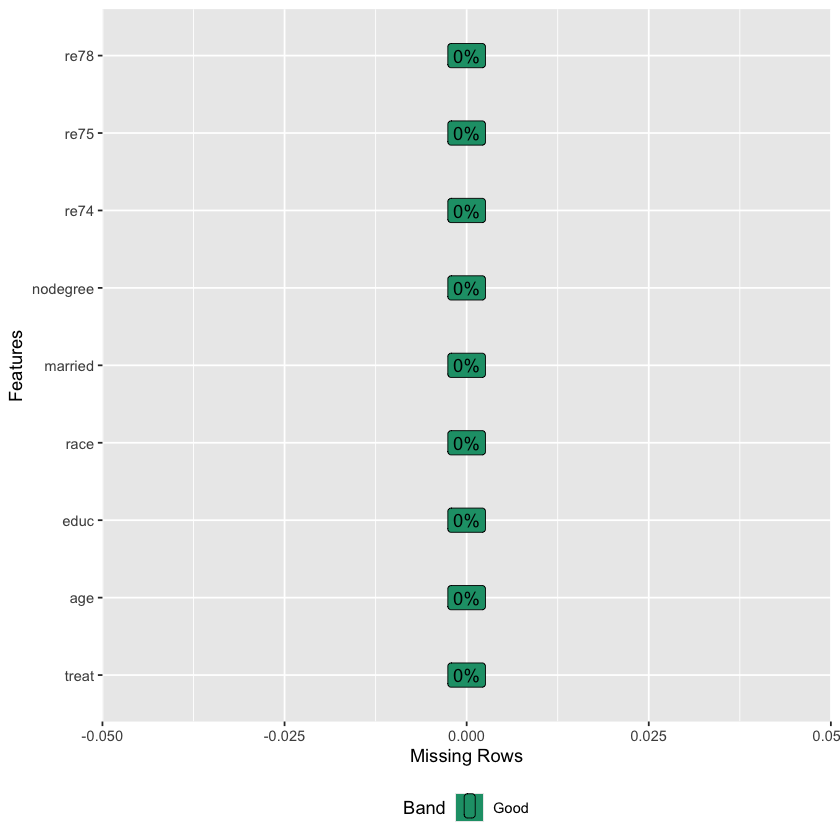

In [11]:
plot_missing(lalonde)

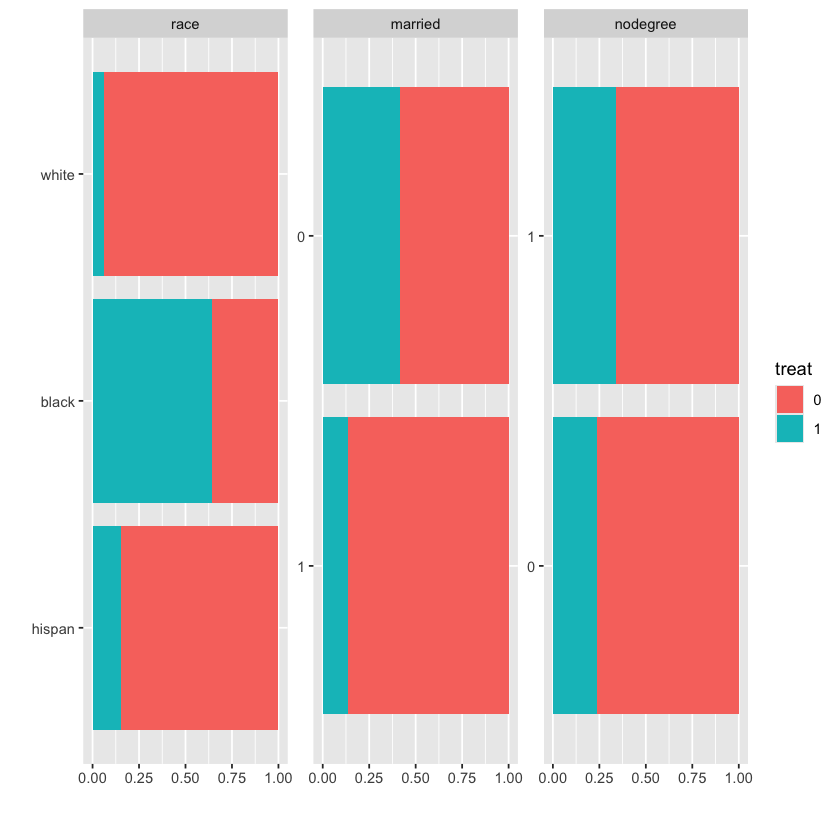

In [12]:
library(DataExplorer)

plot_bar(lalonde, by = "treat")

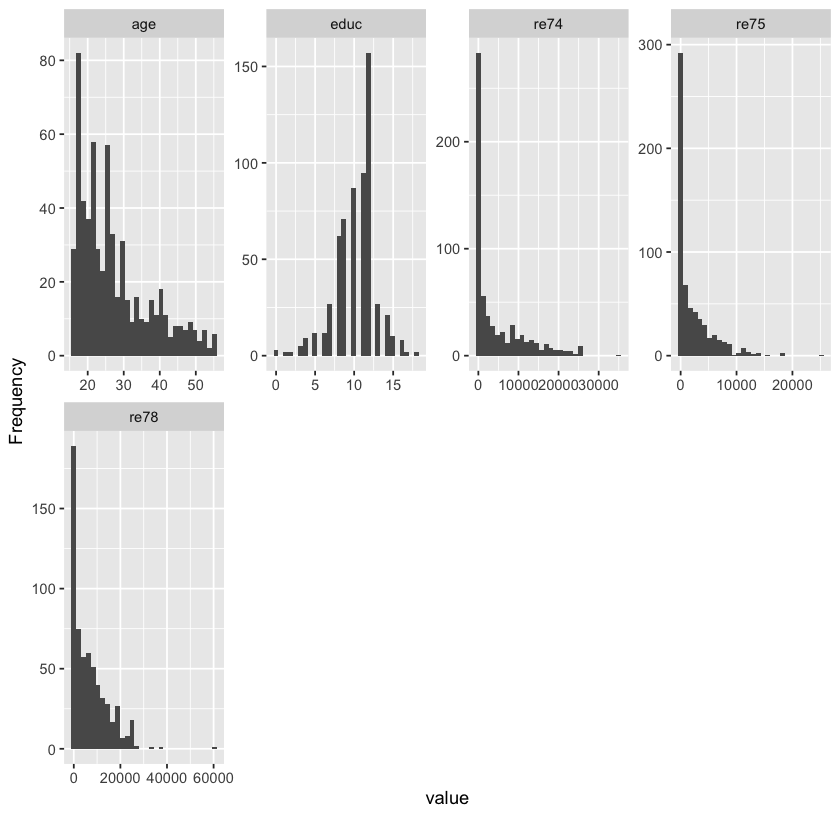

In [14]:
plot_histogram(lalonde)

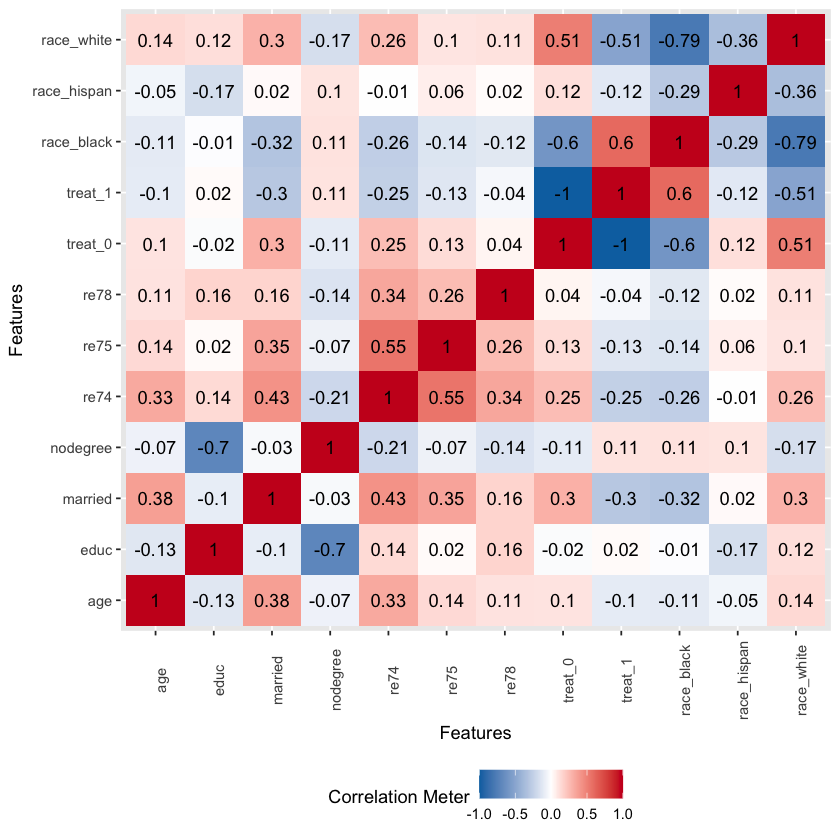

In [18]:
plot_correlation(lalonde)

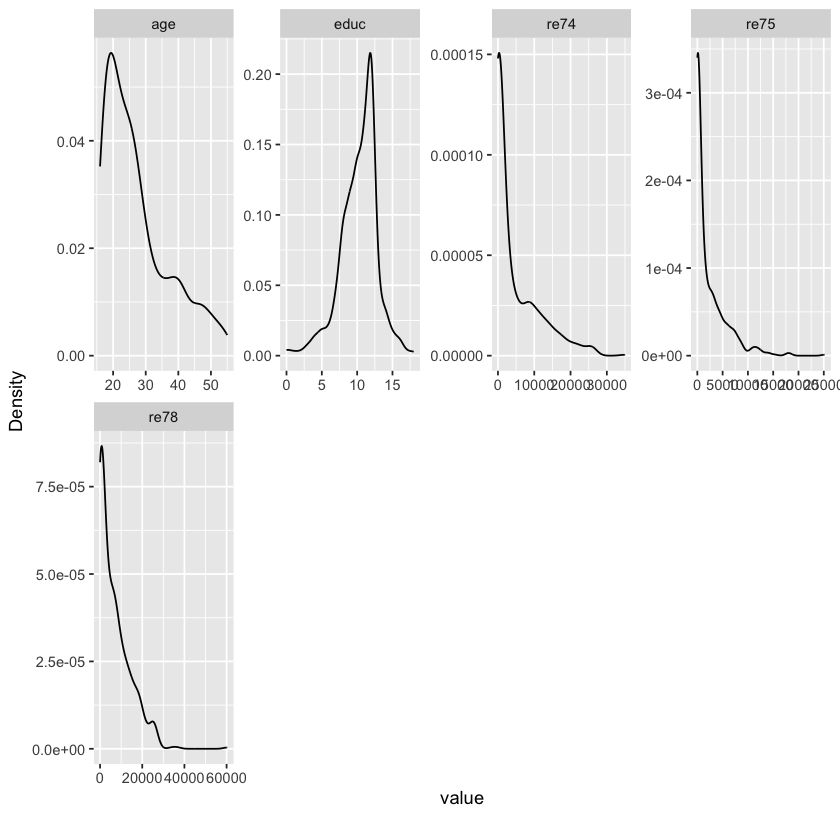

In [16]:
plot_density(lalonde)

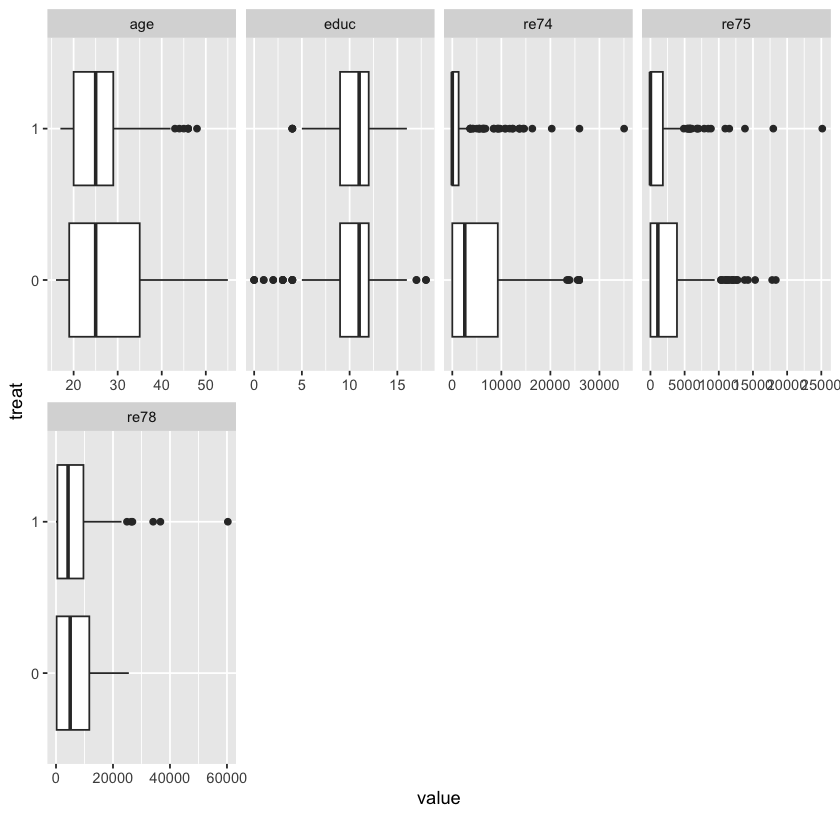

In [15]:
plot_boxplot(lalonde,by = "treat")

##  检查初始不平衡

In [19]:
# 检查初始不平衡
m_out0 <- matchit(
  treat ~ age + educ + race + married + nodegree + re74 + re75,
  data = lalonde,
  method = NULL,
  distance = "glm"
)

# 打印结果
summary(m_out0)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = NULL, distance = "glm")

Summary of Balance for All Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5774        0.1822          1.7941     0.9211    0.3774
age              25.8162       28.0303         -0.3094     0.4400    0.0813
educ             10.3459       10.2354          0.0550     0.4959    0.0347
raceblack         0.8432        0.2028          1.7615          .    0.6404
racehispan        0.0595        0.1422         -0.3498          .    0.0827
racewhite         0.0973        0.6550         -1.8819          .    0.5577
married           0.1892        0.5128         -0.8263          .    0.3236
nodegree          0.7081        0.5967          0.2450          .    0.1114
re74           2095.5737     5619.2365         -0.7211     0.5181    0.2248
re75           1532.0553     2466.4844         -0.2903     0.9563

In [20]:
data_treat <- lalonde %>% filter(treat == 1) %>% select(educ)
data_control <- lalonde %>% filter(treat == 0) %>% select(educ)

# 计算各组样本量
n_treat <- nrow(data_treat)
n_control <- nrow(data_control)
print(str_glue("treat n: {n_treat}"))
print(str_glue("control n: {n_control}"))

# 计算均值
mean_treat <- mean(data_treat$educ)
mean_contorl <- mean(data_control$educ)
print(str_glue("treat mean: {mean_treat}"))
print(str_glue("control mean: {mean_contorl}"))

# 计算标准差
sd_treat <- sd(data_treat$educ)
sd_contorl <- sd(data_control$educ)
print(str_glue("treat sd: {sd_treat}"))
print(str_glue("control sd: {sd_contorl}"))

# 计算标准化均值差异
# 需要注意不同类型的处理效应所使用标准差不同
# ATT使用处理组标准差，默认使用
# ATC使用对照组标准差
# ATE使用两组标准差的平均，没有加权
smd <- (mean_treat - mean_contorl) / sd_treat
print(str_glue("smd: {smd}"))

# 计算方差比
var_ratio <- sd_treat^2 / sd_contorl^2
print(str_glue("var_ratio: {var_ratio}"))

# 计算经验分布
ecdf_treat <- ecdf(data_treat$educ)
ecdf_control <- ecdf(data_control$educ)
z <- unique(c(data_treat$educ, data_control$educ))
ecdf_treat_values <- ecdf_treat(z)
ecdf_control_values <- ecdf_control(z)
ecdf_mean <- mean(abs(ecdf_treat_values - ecdf_control_values))
print(str_glue("ecdf_mean: {ecdf_mean}"))
ecdf_max <- max(abs(ecdf_treat_values - ecdf_control_values))
print(str_glue("ecdf_max: {ecdf_max}"))

treat n: 185
control n: 429
treat mean: 10.3459459459459
control mean: 10.2354312354312
treat sd: 2.01065025640563
control sd: 2.85523844087594
smd: 0.0549646613888354
var_ratio: 0.495893371429211
ecdf_mean: 0.0347223189328453
ecdf_max: 0.111371511371511


## 开始匹配

In [21]:
# 1:1 NN PS matching w/o replacement
m_out1 <- matchit(
  treat ~ age + educ + race + married + nodegree + re74 + re75,
  data = lalonde,
  method = "nearest",
  distance = "glm"
)

m_out1

A `matchit` object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 614 (original), 370 (matched)
 - target estimand: ATT
 - covariates: age, educ, race, married, nodegree, re74, re75

In [22]:
m_out1$match.matrix

NSW1,PSID300
NSW2,PSID205
NSW3,PSID41
NSW4,PSID179
NSW5,PSID238
NSW6,PSID6
NSW7,PSID271
NSW8,PSID374
NSW9,PSID423
NSW10,PSID344
NSW11,PSID354


In [23]:
m_out1$subclass

NSW1    NSW2    NSW3    NSW4    NSW5    NSW6    NSW7    NSW8    NSW9   NSW10 
      1       2       3       4       5       6       7       8       9      10 
  NSW11   NSW12   NSW13   NSW14   NSW15   NSW16   NSW17   NSW18   NSW19   NSW20 
     11      12      13      14      15      16      17      18      19      20 
  NSW21   NSW22   NSW23   NSW24   NSW25   NSW26   NSW27   NSW28   NSW29   NSW30 
     21      22      23      24      25      26      27      28      29      30 
  NSW31   NSW32   NSW33   NSW34   NSW35   NSW36   NSW37   NSW38   NSW39   NSW40 
     31      32      33      34      35      36      37      38      39      40 
  NSW41   NSW42   NSW43   NSW44   NSW45   NSW46   NSW47   NSW48   NSW49   NSW50 
     41      42      43      44      45      46      47      48      49      50 
  NSW51   NSW52   NSW53   NSW54   NSW55   NSW56   NSW57   NSW58   NSW59   NSW60 
     51      52      53      54      55      56      57      58      59      60 
  NSW61   NSW62   NSW63   NSW64   NSW65   NSW66   NSW67   NSW68   NSW69   NSW70 
     61      62      63      64      65      66      67      68      69      70 
  NSW71   NSW72   NSW73   NSW74   NSW75   NSW76   NSW77   NSW78   NSW79   NSW80 
     71      72      73      74      75      76      77      78      79      80 
  NSW81   NSW82   NSW83   NSW84   NSW85   NSW86   NSW87   NSW88   NSW89   NSW90 
     81      82      83      84      85      86      87      88      89      90 
  NSW91   NSW92   NSW93   NSW94   NSW95   NSW96   NSW97   NSW98   NSW99  NSW100 
     91      92      93      94      95      96      97      98      99     100 
 NSW101  NSW102  NSW103  NSW104  NSW105  NSW106  NSW107  NSW108  NSW109  NSW110 
    101     102     103     104     105     106     107     108     109     110 
 NSW111  NSW112  NSW113  NSW114  NSW115  NSW116  NSW117  NSW118  NSW119  NSW120 
    111     112     113     114     115     116     117     118     119     120 
 NSW121  NSW122  NSW123  NSW124  NSW125  NSW126  NSW127  NSW128  NSW129  NSW130 
    121     122     123     124     125     126     127     128     129     130 
 NSW131  NSW132  NSW133  NSW134  NSW135  NSW136  NSW137  NSW138  NSW139  NSW140 
    131     132     133     134     135     136     137     138     139     140 
 NSW141  NSW142  NSW143  NSW144  NSW145  NSW146  NSW147  NSW148  NSW149  NSW150 
    141     142     143     144     145     146     147     148     149     150 
 NSW151  NSW152  NSW153  NSW154  NSW155  NSW156  NSW157  NSW158  NSW159  NSW160 
    151     152     153     154     155     156     157     158     159     160 
 NSW161  NSW162  NSW163  NSW164  NSW165  NSW166  NSW167  NSW168  NSW169  NSW170 
    161     162     163     164     165     166     167     168     169     170 
 NSW171  NSW172  NSW173  NSW174  NSW175  NSW176  NSW177  NSW178  NSW179  NSW180 
    171     172     173     174     175     176     177     178     179     180 
 NSW181  NSW182  NSW183  NSW184  NSW185   PSID1   PSID2   PSID3   PSID4   PSID5 
    181     182     183     184     185    <NA>    <NA>    <NA>    <NA>     147 
  PSID6   PSID7   PSID8   PSID9  PSID10  PSID11  PSID12  PSID13  PSID14  PSID15 
      6    <NA>      57    <NA>    <NA>    <NA>    <NA>    <NA>    <NA>      40 
 PSID16  PSID17  PSID18  PSID19  PSID20  PSID21  PSID22  PSID23  PSID24  PSID25 
   <NA>      74    <NA>    <NA>    <NA>    <NA>    <NA>    <NA>      84    <NA> 
 PSID26  PSID27  PSID28  PSID29  PSID30  PSID31  PSID32  PSID33  PSID34  PSID35 
   <NA>      97    <NA>    <NA>    <NA>     153    <NA>     124    <NA>    <NA> 
 PSID36  PSID37  PSID38  PSID39  PSID40  PSID41  PSID42  PSID43  PSID44  PSID45 
   <NA>    <NA>    <NA>    <NA>    <NA>       3    <NA>    <NA>    <NA>    <NA> 
 PSID46  PSID47  PSID48  PSID49  PSID50  PSID51  PSID52  PSID53  PSID54  PSID55 
     90    <NA>     161    <NA>    <NA>    <NA>    <NA>    <NA>    <NA>    <NA> 
 PSID56  PSID57  PSID58  PSID59  PSID60  PSID61  PSID62  PSID63  PSID64  PSID65 
   <NA>    <NA>    <NA>      48   

## 评估匹配质量

In [24]:
# Checking balance after NN matching
summary(m_out1, un = FALSE)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = "nearest", distance = "glm")

Summary of Balance for Matched Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5774        0.3629          0.9739     0.7566    0.1321
age              25.8162       25.3027          0.0718     0.4568    0.0847
educ             10.3459       10.6054         -0.1290     0.5721    0.0239
raceblack         0.8432        0.4703          1.0259          .    0.3730
racehispan        0.0595        0.2162         -0.6629          .    0.1568
racewhite         0.0973        0.3135         -0.7296          .    0.2162
married           0.1892        0.2108         -0.0552          .    0.0216
nodegree          0.7081        0.6378          0.1546          .    0.0703
re74           2095.5737     2342.1076         -0.0505     1.3289    0.0469
re75           1532.0553     1614.7451         -0.0257  

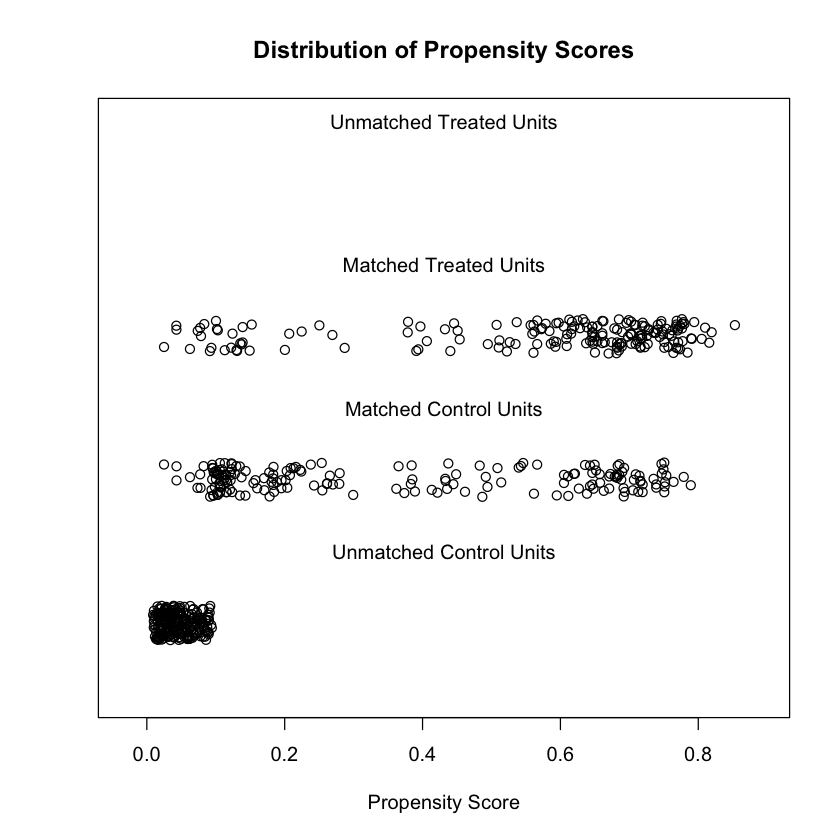

In [25]:
par(bg = 'white')
plot(m_out1, type = "jitter", interactive = FALSE)

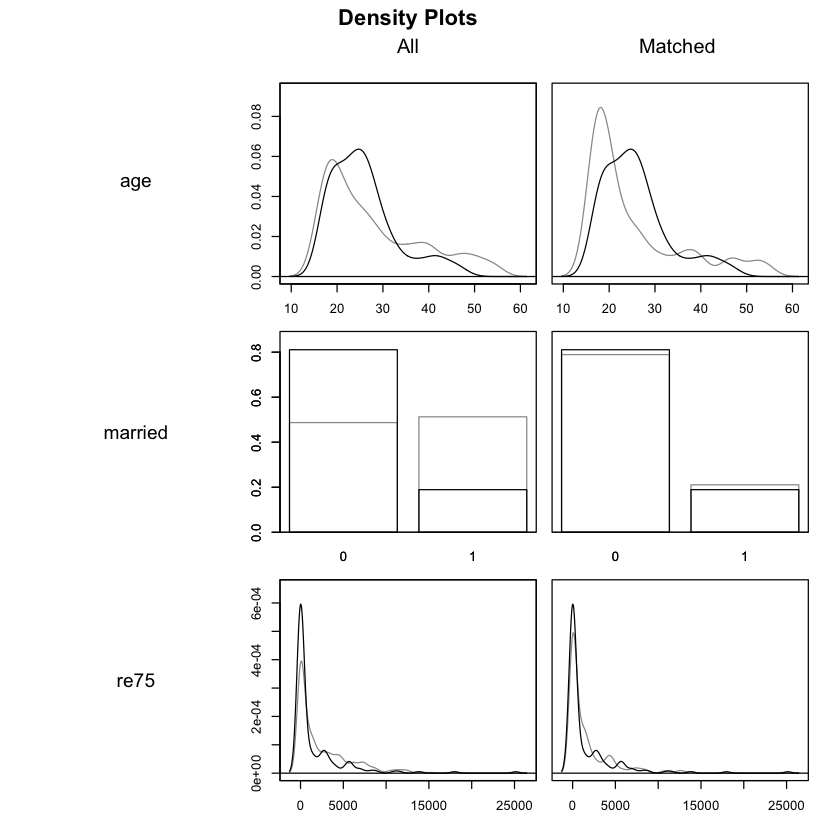

In [26]:
par(bg = 'white')
plot(m_out1, type = "density", interactive = FALSE,
     which.xs = ~age + married + re75)

## 尝试不同的匹配方法

In [19]:
install.packages("matchit2full")

Warning message:
"package 'matchit2full' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"


In [26]:
install.packages("optmatch")

also installing the dependency 'rlemon'





The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpQj7tUh/downloaded_packages


In [27]:
# Full matching on a probit PS
m_out2 <- matchit(
  treat ~ age + educ + race + married + nodegree + re74 + re75,
  data = lalonde,
  method = "full",
  distance = "glm",
  link = "probit"
)

m_out2

A `matchit` object
 - method: Optimal full matching
 - distance: Propensity score
             - estimated with probit regression
 - number of obs.: 614 (original), 614 (matched)
 - target estimand: ATT
 - covariates: age, educ, race, married, nodegree, re74, re75

In [28]:
summary(m_out2, un = FALSE)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = "full", distance = "glm", 
    link = "probit")

Summary of Balance for Matched Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5773        0.5764          0.0045     0.9949    0.0043
age              25.8162       25.5347          0.0393     0.4790    0.0787
educ             10.3459       10.5381         -0.0956     0.6192    0.0253
raceblack         0.8432        0.8389          0.0119          .    0.0043
racehispan        0.0595        0.0492          0.0435          .    0.0103
racewhite         0.0973        0.1119         -0.0493          .    0.0146
married           0.1892        0.1633          0.0660          .    0.0259
nodegree          0.7081        0.6577          0.1110          .    0.0504
re74           2095.5737     2100.2150         -0.0009     1.3467    0.0314
re75           1532.0553     1561.442

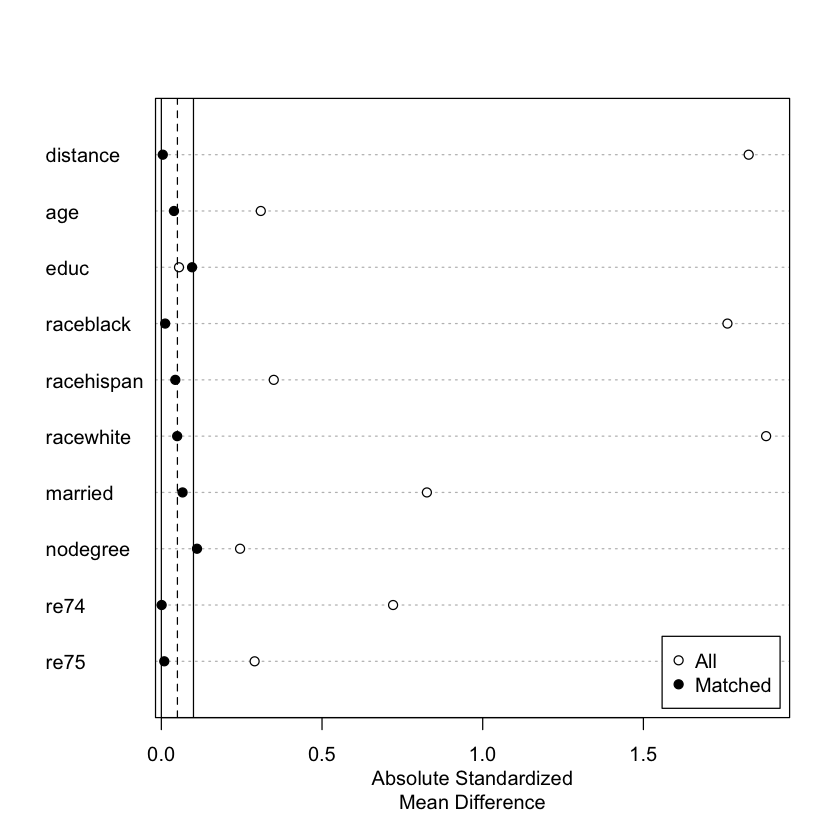

In [29]:
par(bg = 'white')
plot(summary(m_out2))

## 估计处理效应

In [30]:
m_data <- match_data(m_out2)

head(m_data)

,treat,age,educ,race,married,nodegree,re74,re75,re78,distance,weights,subclass
,<fct>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
NSW1,1,37,11,black,1,1,0,0,9930.0460,0.6356769,1,54
NSW2,1,22,9,hispan,0,1,0,0,3595.8940,0.2298151,1,62
NSW3,1,30,12,black,0,0,0,0,24909.4500,0.6813558,1,69
NSW4,1,27,11,black,0,1,0,0,7506.1460,0.7690590,1,78
NSW5,1,33,8,black,0,1,0,0,289.7899,0.6954138,1,85
NSW6,1,22,9,black,0,1,0,0,4056.4940,0.6943658,1,91


In [ ]:
m_data %>%
  group_by(subclass) %>%
  summarise(
    n = n(),
  ) %>%
  head()

subclass,n
<fct>,<int>
1,4
2,2
3,2
4,2
5,38
6,3


In [53]:
# 直接t检验
t.test(
  re78 ~ treat,
  data = m_data
)


	Welch Two Sample t-test

data:  re78 by treat
t = 0.93773, df = 326.41, p-value = 0.3491
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -697.192 1967.244
sample estimates:
mean in group 0 mean in group 1 
       6984.170        6349.144 


In [73]:
# 进行线性回归
fit <- lm(
  re78 ~ treat + race + nodegree + re75,
  data = m_data,
  weights = weights
)

summary(fit)


Call:
lm(formula = re78 ~ treat + race + nodegree + re75, data = m_data, 
    weights = weights)

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-17173  -2829   -632   1828  54931 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.753e+03  5.037e+02   9.437  < 2e-16 ***
treat        1.992e+03  5.365e+02   3.713 0.000224 ***
racehispan   9.580e+02  1.113e+03   0.860 0.389910    
racewhite    1.566e+03  7.999e+02   1.958 0.050726 .  
nodegree    -2.117e+03  5.309e+02  -3.988 7.49e-05 ***
re75         5.832e-01  9.026e-02   6.461 2.14e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6090 on 608 degrees of freedom
Multiple R-squared:  0.1209,	Adjusted R-squared:  0.1136 
F-statistic: 16.72 on 5 and 608 DF,  p-value: 1.723e-15


In [74]:
library(lmtest)
library(sandwich)
coeftest(fit, vcov. = vcovCL, cluster = ~subclass)


t test of coefficients:

               Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)  4753.41924   954.45105  4.9803 8.284e-07 ***
treat        1991.96771   719.29583  2.7693  0.005789 ** 
racehispan    958.03099  1431.28512  0.6694  0.503526    
racewhite    1565.99412   818.26522  1.9138  0.056115 .  
nodegree    -2116.91814   929.09501 -2.2785  0.023044 *  
re75            0.58316     0.11752  4.9623 9.056e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [50]:
install.packages("marginaleffects")


The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpQj7tUh/downloaded_packages


In [75]:
library(marginaleffects)

avg_comparisons(
  fit,
  variables = "treat",
  vcov = ~subclass,
  newdata = subset(treat == 1)
)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
treat,1 - 0,1991.968,719.2958,2.76933,0.005617167,7.475942,582.1738,3401.762,2636.501,4628.469,4628.469


In [72]:
# 使用survey包进行加权
library(survey)

fit_svy <- svyglm(
  re78 ~ treat + race + nodegree + re75,
  design = svydesign(
    ids = ~subclass,
    data = m_data,
    weights = ~weights
  ),
  family = gaussian()
)

# tidy结果
library(broom)
tidy(fit_svy)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4753.4192405,950.5505382,5.0007012,2.443059e-06
treat,1991.9677052,716.3563182,2.7806940,6.482725e-03
racehispan,958.0309873,1425.4359491,0.6720968,5.030719e-01
racewhite,1565.9941165,814.9212502,1.9216509,5.749660e-02
nodegree,-2116.9181445,925.2981161,-2.2878228,2.425345e-02
re75,0.5831594,0.1170379,4.9826525,2.632745e-06


# 平衡评估

## 使用{MacthIt}评估平衡

### summary.matchit()

In [4]:
library("MatchIt")
data("lalonde", package = "MatchIt")

#1:1 NN matching w/ replacement on a logistic regression PS
m_out <- matchit(
  treat ~ age + educ + race + married + nodegree + re74 + re75, data = lalonde,
  replace = TRUE
)

m_out

A `matchit` object
 - method: 1:1 nearest neighbor matching with replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 614 (original), 267 (matched)
 - target estimand: ATT
 - covariates: age, educ, race, married, nodegree, re74, re75

In [5]:
summary(
  m_out,
  addlvariables = ~ I(age^2) + I(re74==0) + I(re75==0) + educ:race
)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, replace = TRUE)

Summary of Balance for All Data:
                 Means Treated Means Control Std. Mean Diff. Var. Ratio
distance                0.5774        0.1822          1.7941     0.9211
age                    25.8162       28.0303         -0.3094     0.4400
educ                   10.3459       10.2354          0.0550     0.4959
raceblack               0.8432        0.2028          1.7615          .
racehispan              0.0595        0.1422         -0.3498          .
racewhite               0.0973        0.6550         -1.8819          .
married                 0.1892        0.5128         -0.8263          .
nodegree                0.7081        0.5967          0.2450          .
re74                 2095.5737     5619.2365         -0.7211     0.5181
re75                 1532.0553     2466.4844         -0.2903     0.9563
I(age^2)              717.3946      901.7786      

### plot.summary.matchit()

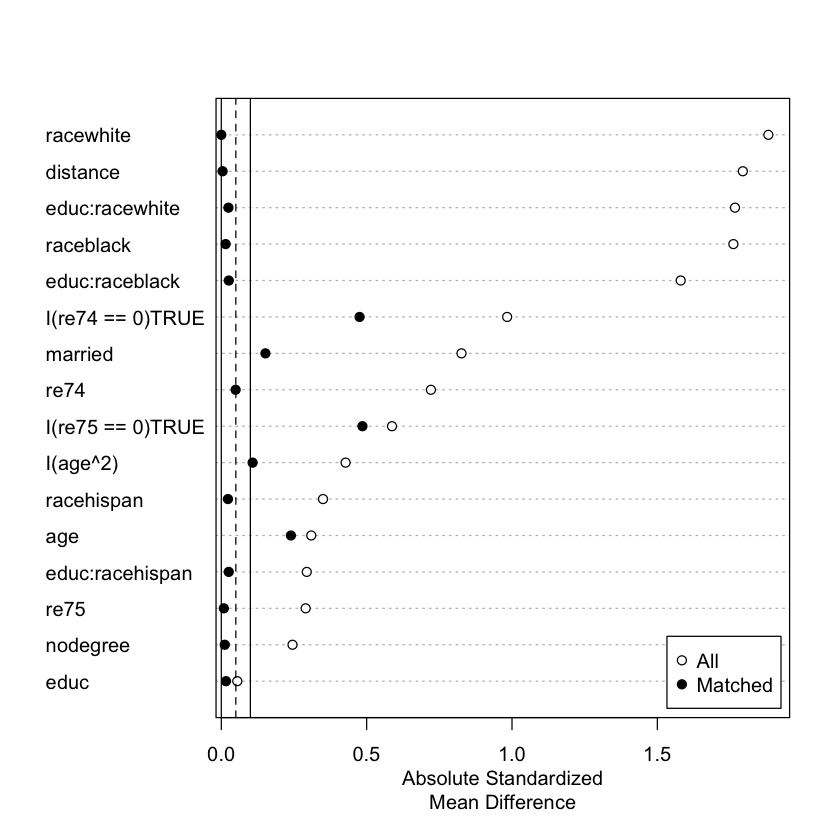

In [37]:
m_sum <- summary(
  m_out,
  addlvariables = ~ I(age^2) + I(re74==0) + I(re75==0) + educ:race
)

par(bg = 'white')
plot(m_sum, var.order = "unmatched")

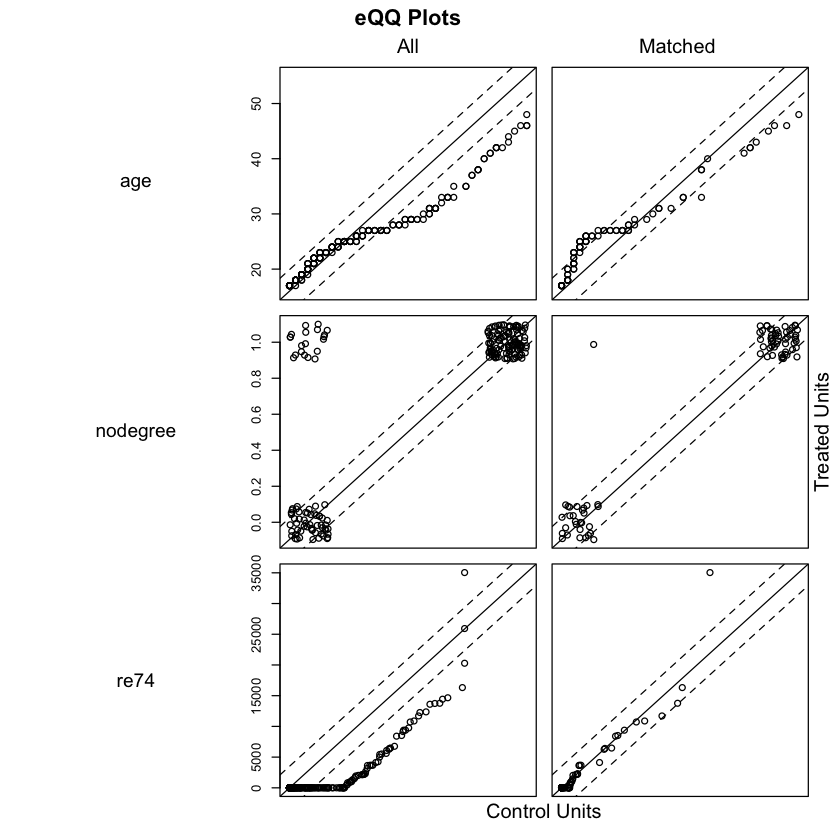

In [41]:
#eQQ plot
par(bg = 'white')
plot(m_out, type = "qq", which.xs = ~age + nodegree + re74)

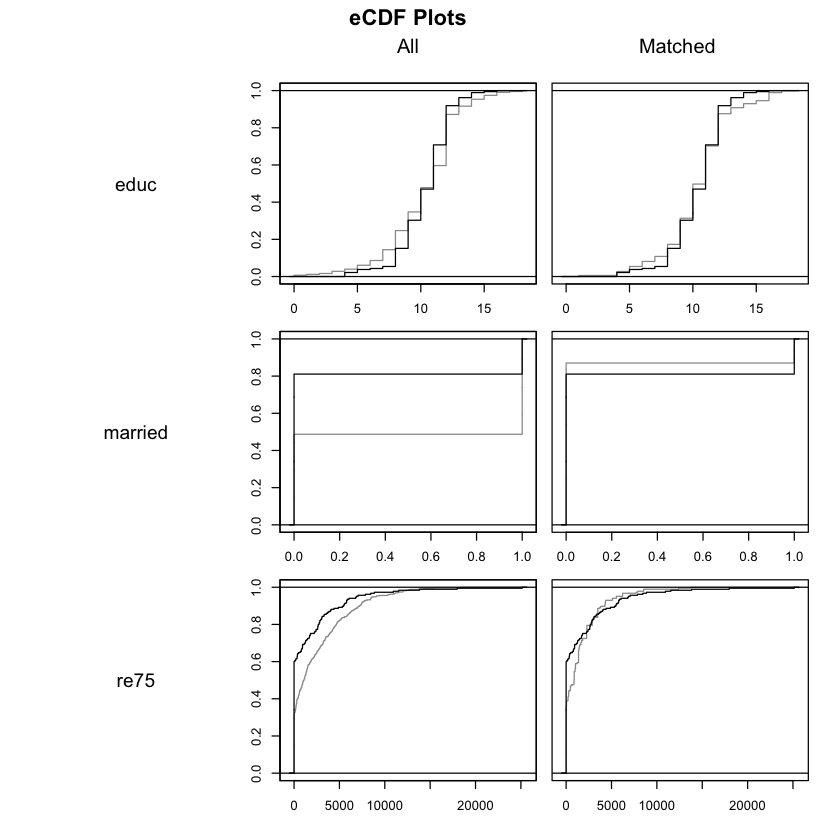

In [43]:
#eCDF plot
par(bg = 'white')
plot(m_out, type = "ecdf", which.xs = ~educ + married + re75)

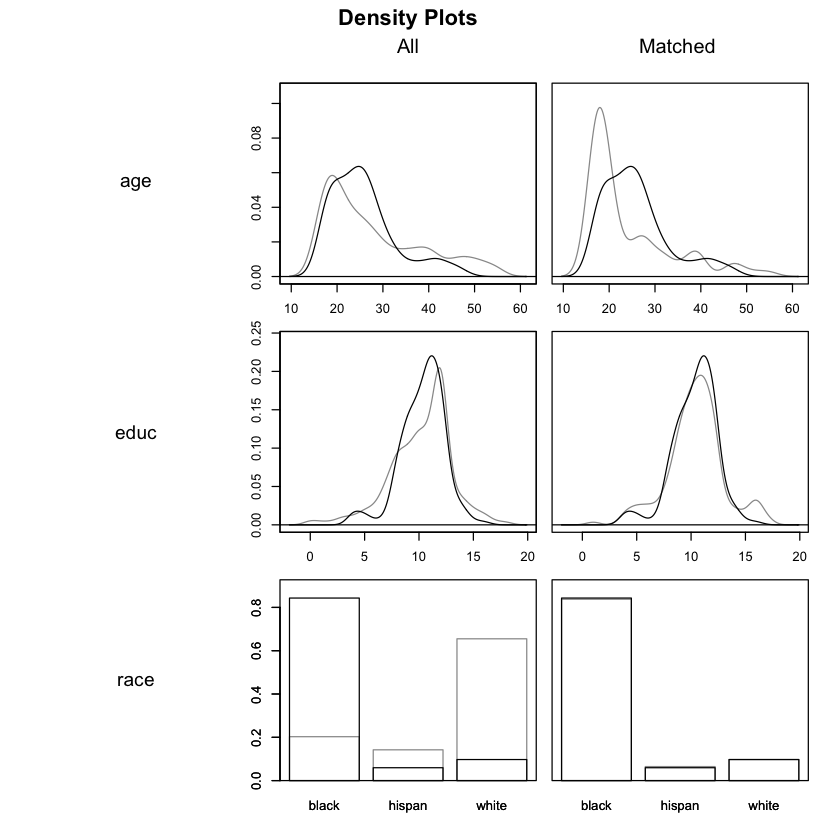

In [45]:
#density plot
par(bg = 'white')
plot(m_out, type = "density", which.xs = ~age + educ + race)

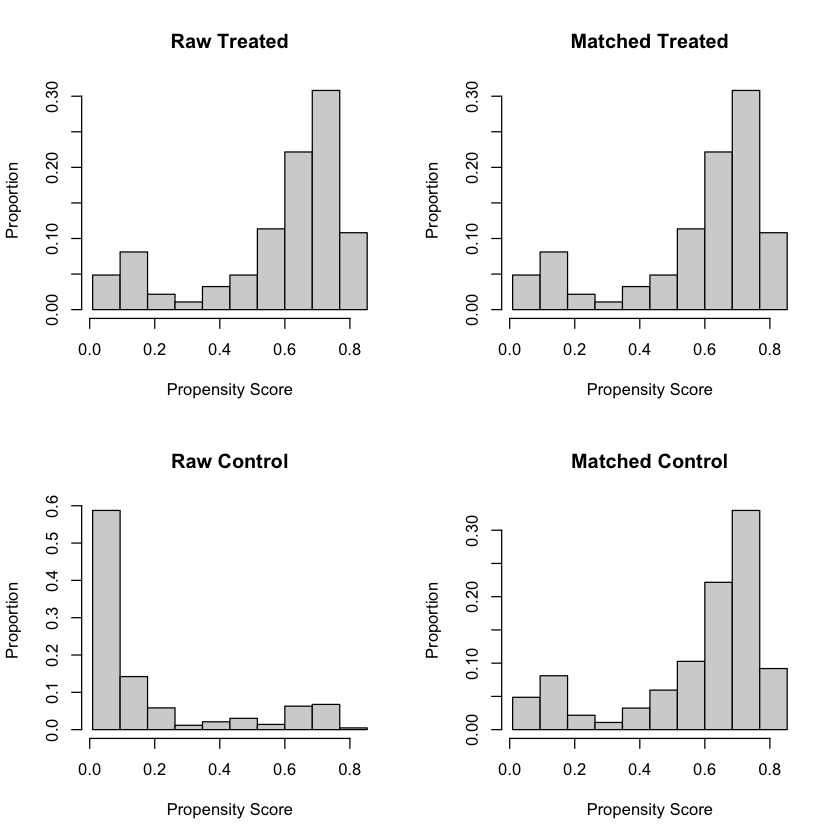

In [46]:
# histogram
par(bg = 'white')
plot(m_out, type = "hist", which.xs = ~age + educ + race)

To identify the units, use first mouse button; to stop, use second.


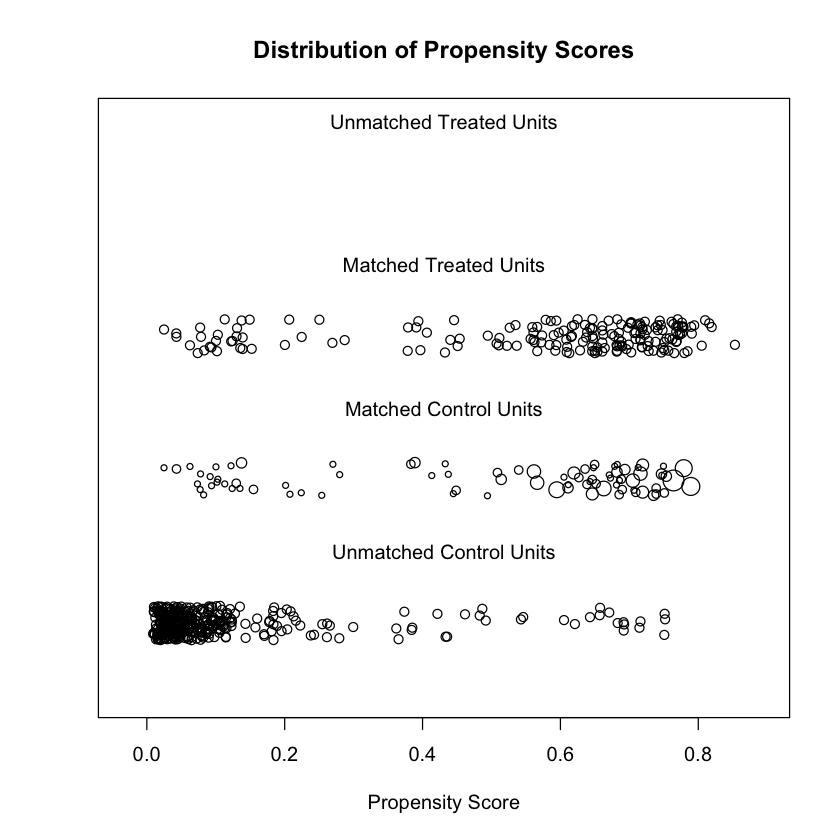

In [47]:
# jitter plot
par(bg = 'white')
plot(m_out, type = "jitter", which.xs = ~age + educ + race)

## 子分类后评价平衡

In [48]:
#Subclassification on a logistic regression PS
s_out <- matchit(
  treat ~ age + educ + race + married + nodegree + re74 + re75,
  data = lalonde,
  method = "subclass",
  subclass = 4
)

s_out

A `matchit` object
 - method: Subclassification (4 subclasses)
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 614 (original), 614 (matched)
 - target estimand: ATT
 - covariates: age, educ, race, married, nodegree, re74, re75

In [49]:
summary(s_out)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = "subclass", subclass = 4)

Summary of Balance for All Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5774        0.1822          1.7941     0.9211    0.3774
age              25.8162       28.0303         -0.3094     0.4400    0.0813
educ             10.3459       10.2354          0.0550     0.4959    0.0347
raceblack         0.8432        0.2028          1.7615          .    0.6404
racehispan        0.0595        0.1422         -0.3498          .    0.0827
racewhite         0.0973        0.6550         -1.8819          .    0.5577
married           0.1892        0.5128         -0.8263          .    0.3236
nodegree          0.7081        0.5967          0.2450          .    0.1114
re74           2095.5737     5619.2365         -0.7211     0.5181    0.2248
re75           1532.0553     2466.4844         -0.2903     0.95

In [50]:
summary(s_out, subclass = TRUE, un = FALSE)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = "subclass", subclass = 4)

Summary of Balance by Subclass:

- Subclass 1
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.2392        0.0954          0.8795     2.4941    0.3135
age              26.4783       28.8000         -0.3445     0.3938    0.0897
educ             10.3043       10.2137          0.0396     0.6201    0.0253
raceblack         0.3696        0.0630          0.6351          .    0.3066
racehispan        0.2391        0.1671          0.1688          .    0.0720
racewhite         0.3913        0.7699         -0.7757          .    0.3786
married           0.3696        0.5890         -0.4547          .    0.2195
nodegree          0.5870        0.5836          0.0069          .    0.0034
re74           5430.5389     6363.9132         -0.1175     1.2984    0.0868
re75           2929.0394     2699.3994          0.

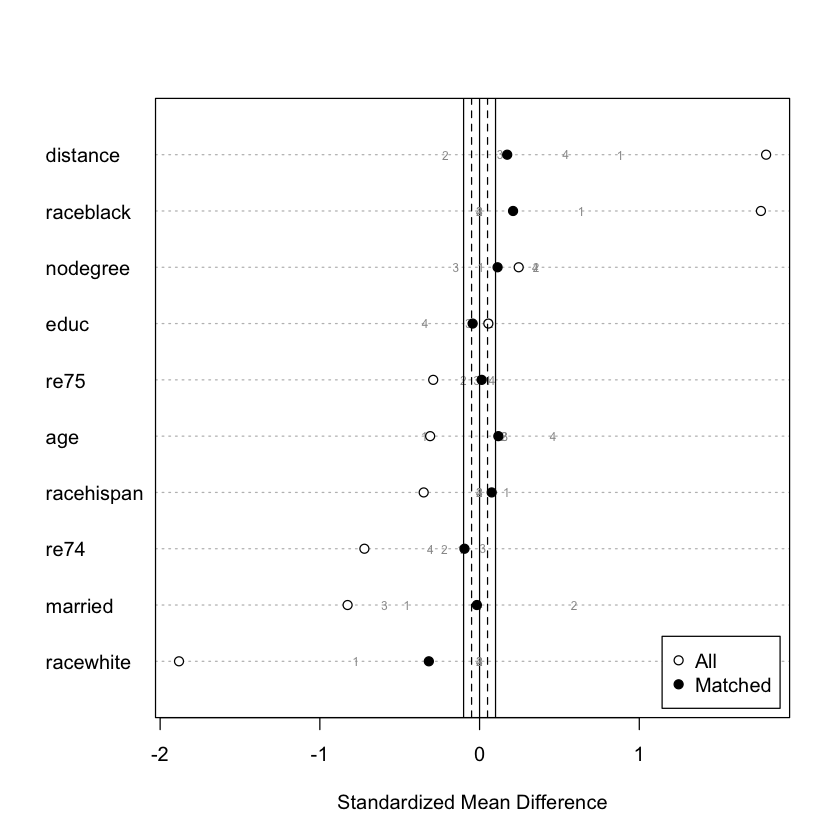

In [52]:
s <- summary(s_out, subclass = TRUE)

par(bg = 'white')
plot(s, var.order = "unmatched", abs = FALSE)

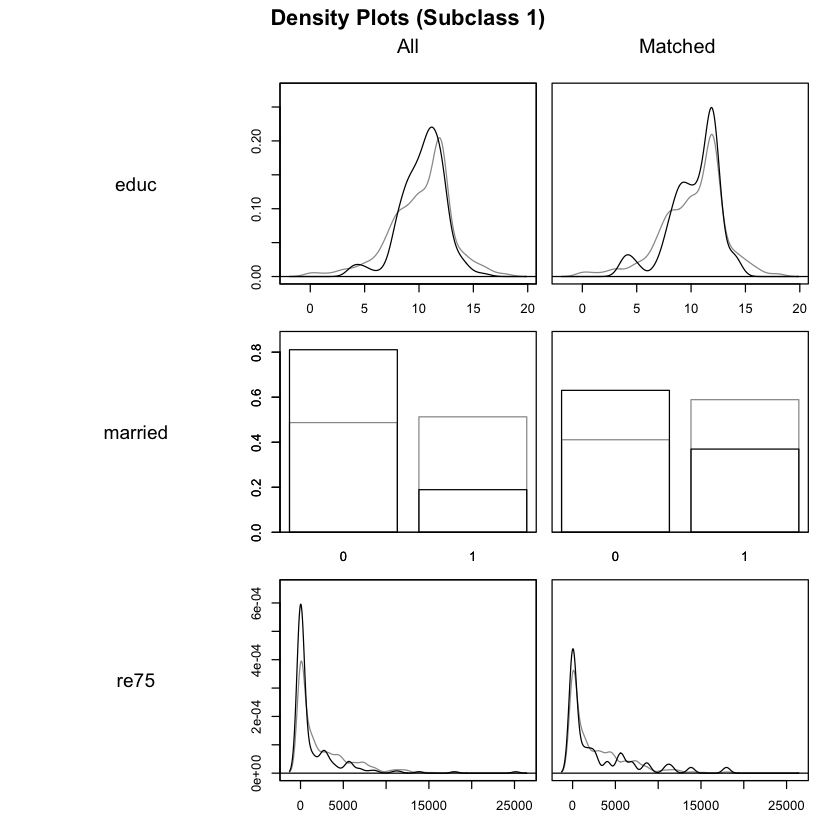

In [54]:
par(bg = 'white')
plot(
  s_out,
  type = "density",
  which.xs = ~educ + married + re75,
  subclass = 1
)

## 使用 {cobalt} 评估平衡

In [55]:
install.packages("cobalt")

Warning message in download.file(url, destfile, method, mode = "wb", ...):
"downloaded length 2587250 != reported length 2909650"
Warning message in download.file(url, destfile, method, mode = "wb", ...):
"URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/cobalt_4.5.5.tgz': Timeout of 60 seconds was reached"


Error in download.file(url, destfile, method, mode = "wb", ...) : 
  download from 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/cobalt_4.5.5.tgz' failed


Warning message in download.packages(pkgs, destdir = tmpd, available = available, :
"download of package 'cobalt' failed"


In [56]:
library("cobalt")

 cobalt (Version 4.5.5, Build Date: 2024-04-02)


Attaching package: 'cobalt'


The following object is masked _by_ '.GlobalEnv':

    lalonde


The following object is masked from 'package:MatchIt':

    lalonde




### bal.tab()

In [57]:
bal.tab(m_out, un = TRUE, stats = c("m", "v", "ks"))

Balance Measures
                Type Diff.Un V.Ratio.Un  KS.Un Diff.Adj V.Ratio.Adj KS.Adj
distance    Distance  1.7941     0.9211 0.6444   0.0044      0.9922 0.0486
age          Contin. -0.3094     0.4400 0.1577   0.2395      0.5565 0.3405
educ         Contin.  0.0550     0.4959 0.1114  -0.0161      0.5773 0.0595
race_black    Binary  0.6404          . 0.6404   0.0054           . 0.0054
race_hispan   Binary -0.0827          . 0.0827  -0.0054           . 0.0054
race_white    Binary -0.5577          . 0.5577   0.0000           . 0.0000
married       Binary -0.3236          . 0.3236   0.0595           . 0.0595
nodegree      Binary  0.1114          . 0.1114   0.0054           . 0.0054
re74         Contin. -0.7211     0.5181 0.4470  -0.0493      1.0363 0.2162
re75         Contin. -0.2903     0.9563 0.2876   0.0087      2.1294 0.2378

Sample sizes
                     Control Treated
All                   429.       185
Matched (ESS)          46.31     185
Matched (Unweighted)   82.       

In [59]:
#Nearest neighbor (NN) matching on the PS
m_out2 <- matchit(
  treat ~ age + educ + race + married + nodegree + re74 + re75,
  data = lalonde
)

#Balance on covariates after full and NN matching
bal.tab(
  treat ~ age + educ + race + married + nodegree + re74 + re75,
  data = lalonde, 
  un = TRUE, 
  weights = list(full = m_out, nn = m_out2)
)

Balance Measures
               Type Diff.Un Diff.full Diff.nn
age         Contin. -0.3094    0.2395  0.0718
educ        Contin.  0.0550   -0.0161 -0.1290
race_black   Binary  0.6404    0.0054  0.3730
race_hispan  Binary -0.0827   -0.0054 -0.1568
race_white   Binary -0.5577    0.0000 -0.2162
married      Binary -0.3236    0.0595 -0.0216
nodegree     Binary  0.1114    0.0054  0.0703
re74        Contin. -0.7211   -0.0493 -0.0505
re75        Contin. -0.2903    0.0087 -0.0257

Effective sample sizes
     Control Treated
All   429.       185
full   46.31     185
nn    185.       185

### love.plot()

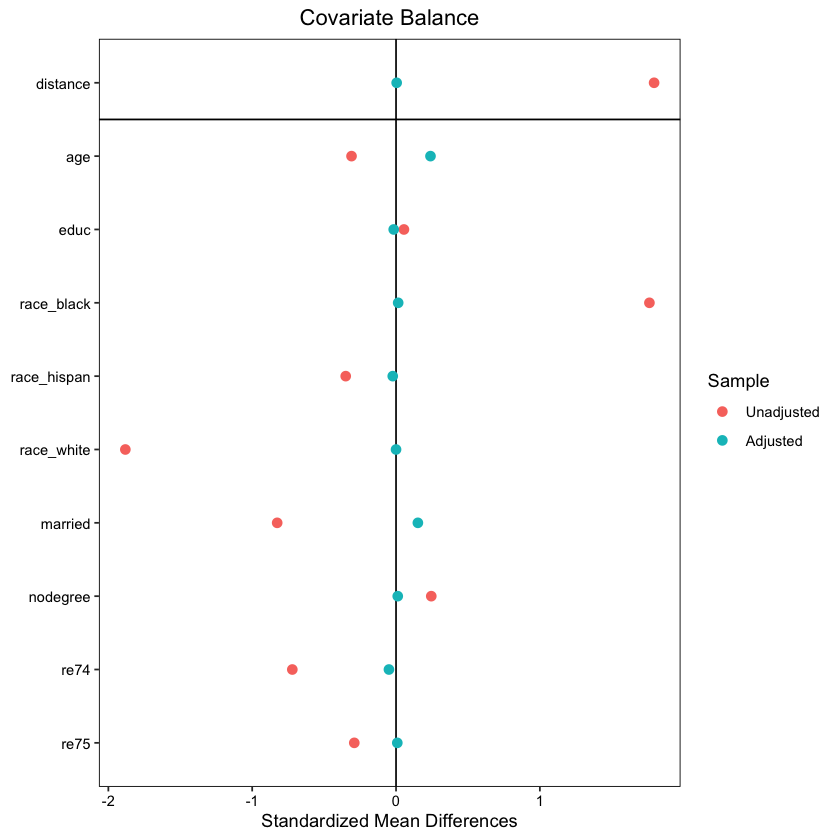

In [60]:
love.plot(m_out, binary = "std")

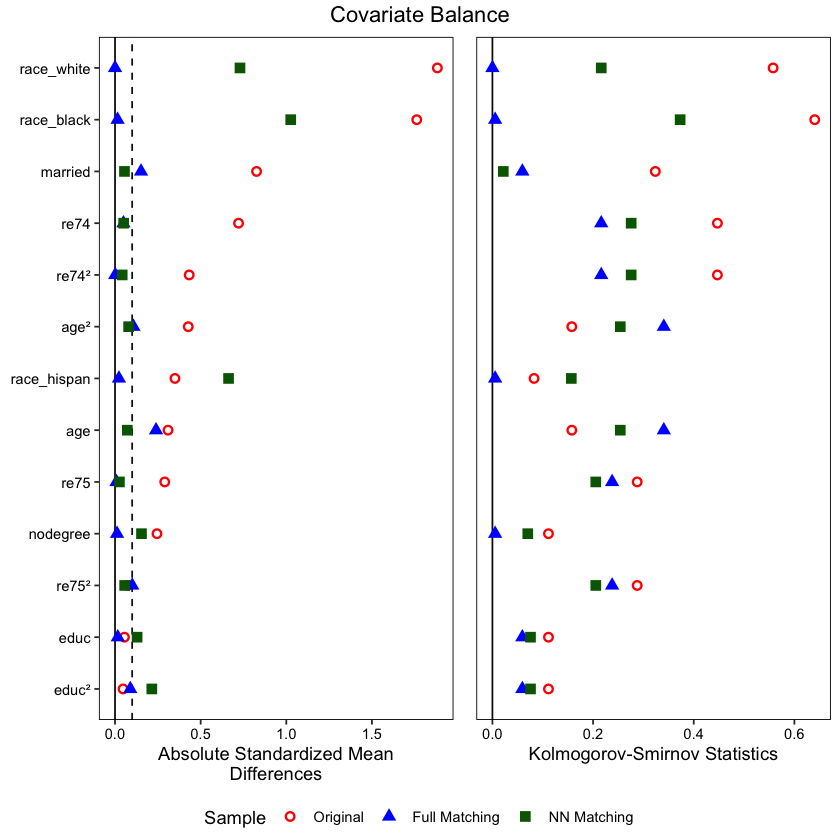

In [63]:
love.plot(
  m_out, stats = c("m", "ks"), poly = 2, abs = TRUE,
  weights = list(nn = m_out2),
  drop.distance = TRUE, thresholds = c(m = .1),
  var.order = "unadjusted", binary = "std",
  shapes = c("circle filled", "triangle", "square"), 
  colors = c("red", "blue", "darkgreen"),
  sample.names = c("Original", "Full Matching", "NN Matching"),
  position = "bottom"
)

### bal.plot()

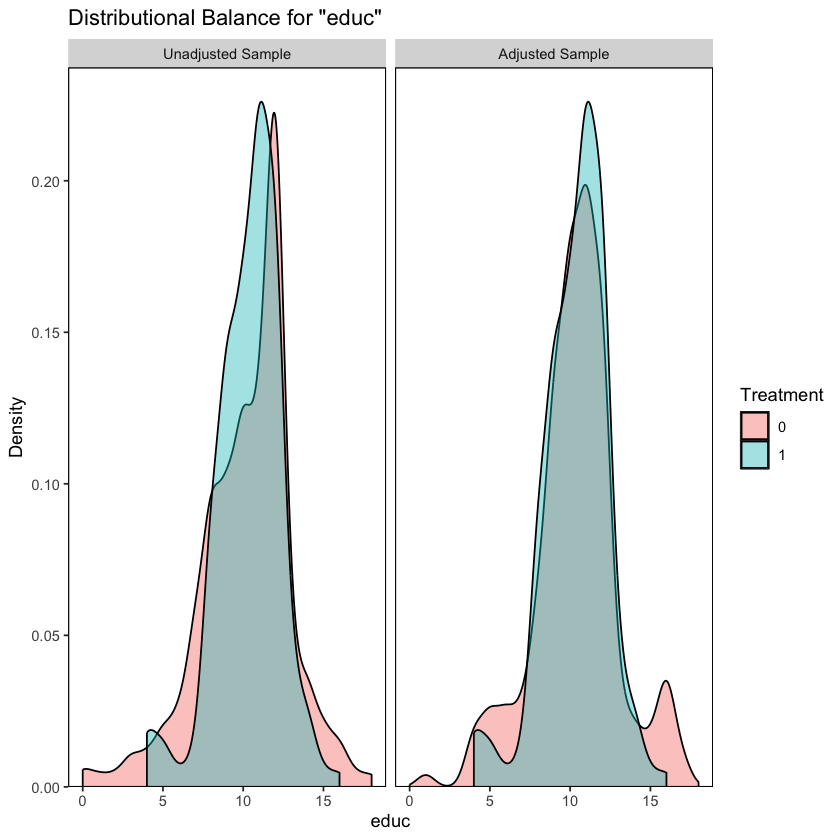

In [64]:
#Density plot for continuous variables
bal.plot(m_out, var.name = "educ", which = "both")

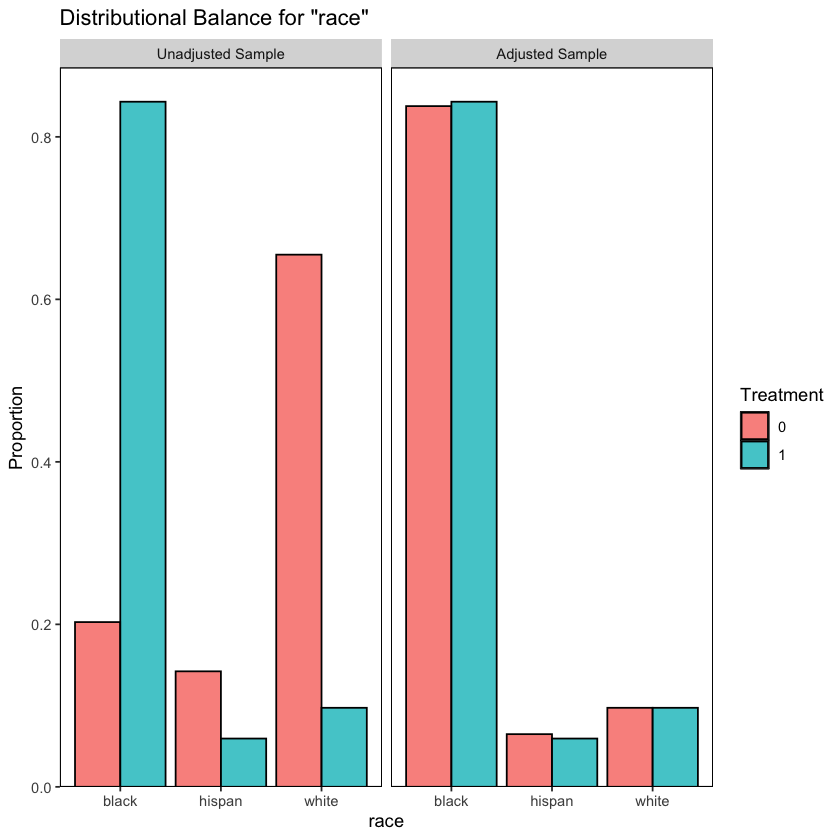

In [65]:
#Bar graph for categorical variables
bal.plot(m_out, var.name = "race", which = "both")

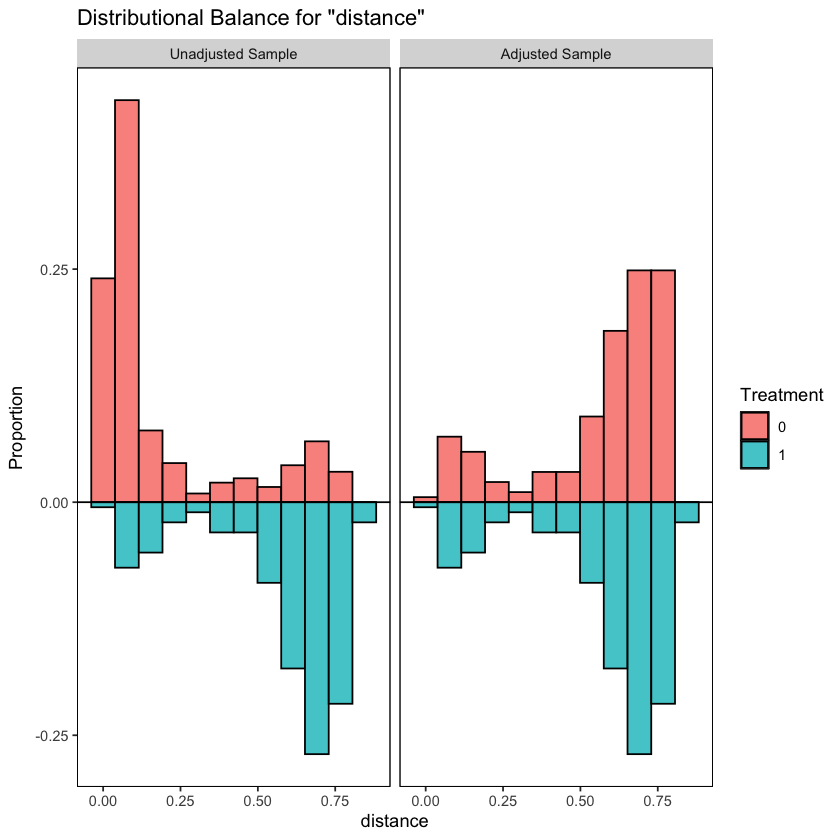

In [66]:
#Mirrored histogram
bal.plot(
  m_out,
  var.name = "distance",
  which = "both",
  type = "histogram",
  mirror = TRUE
)

# 匹配后估计效应量

In [1]:
#Generating data similar to Austin (2009) for demonstrating treatment effect estimation
gen_X <- function(n) {
  X <- matrix(rnorm(9 * n), nrow = n, ncol = 9)
  X[,5] <- as.numeric(X[,5] < .5)
  X
}

#~20% treated
gen_A <- function(X) {
  LP_A <- - 1.2 + log(2)*X[,1] - log(1.5)*X[,2] + log(2)*X[,4] - log(2.4)*X[,5] + log(2)*X[,7] - log(1.5)*X[,8]
  P_A <- plogis(LP_A)
  rbinom(nrow(X), 1, P_A)
}

# Continuous outcome
gen_Y_C <- function(A, X) {
  2*A + 2*X[,1] + 2*X[,2] + 2*X[,3] + 1*X[,4] + 2*X[,5] + 1*X[,6] + rnorm(length(A), 0, 5)
}
#Conditional:
#  MD: 2
#Marginal:
#  MD: 2

# Binary outcome
gen_Y_B <- function(A, X) {
  LP_B <- -2 + log(2.4)*A + log(2)*X[,1] + log(2)*X[,2] + log(2)*X[,3] + log(1.5)*X[,4] + log(2.4)*X[,5] + log(1.5)*X[,6]
  P_B <- plogis(LP_B)
  rbinom(length(A), 1, P_B)
}
#Conditional:
#  OR:   2.4
#  logOR: .875
#Marginal:
#  RD:    .144
#  RR:   1.54
#  logRR: .433
#  OR:   1.92
#  logOR  .655

# Survival outcome
gen_Y_S <- function(A, X) {
  LP_S <- -2 + log(2.4)*A + log(2)*X[,1] + log(2)*X[,2] + log(2)*X[,3] + log(1.5)*X[,4] + log(2.4)*X[,5] + log(1.5)*X[,6]
  sqrt(-log(runif(length(A)))*2e4*exp(-LP_S))
}
#Conditional:
#  HR:   2.4
#  logHR: .875
#Marginal:
#  HR:   1.57
#  logHR: .452

set.seed(19599)

n <- 2000
X <- gen_X(n)
A <- gen_A(X)

Y_C <- gen_Y_C(A, X)
Y_B <- gen_Y_B(A, X)
Y_S <- gen_Y_S(A, X)

d <- data.frame(A, X, Y_C, Y_B, Y_S)

In [2]:
head(d)

,A,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y_C,Y_B,Y_S
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0,0.1725432,-1.4282682,-0.4102538,-2.36059391,1,-1.1198630,0.6397597,-0.4840279,-0.59385184,0.07104125,0,278.45921
2,0,-1.0958972,0.8462679,0.2455671,-0.12332771,1,-2.2686599,-1.4490669,-0.5514441,-0.31439333,0.15618693,0,330.62919
3,0,0.1767731,0.7904544,-0.8435734,0.82365740,1,-0.2220610,0.2970925,-0.6966028,-0.69515666,-0.85179850,1,369.94056
4,0,-0.4595239,0.1725907,1.9542266,-0.62661325,1,-0.4018875,-0.8294041,-0.5383526,0.20729344,-2.35183911,0,91.06106
5,1,0.3563142,-1.8120759,0.8134872,-0.67188804,1,-0.8297074,1.7296758,-0.6438651,-0.02647566,0.68057840,0,182.72605
6,0,-2.4312962,-1.7983652,-1.2939700,0.04609167,1,-1.2418889,-1.1252320,-1.8658885,-0.56513308,-5.62259966,0,2563.73131


## 标准情形

In [4]:
library(MatchIt)

In [5]:
#Variable-ratio NN matching on the PS for the ATT
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  ratio = 2,
  max.controls = 4
)

mV

A `matchit` object
 - method: Variable ratio 2:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 1323 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

In [7]:
library(tidyverse)

match.data(mV) %>% 
  filter(A == 1) %>%
  nrow()

[1] 441

In [8]:
#Extract matched data
md <- match_data(mV)

head(md)

,A,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y_C,Y_B,Y_S,distance,weights,subclass
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,0,0.1725432,-1.4282682,-0.4102538,-2.3605939,1,-1.1198630,0.6397597,-0.4840279,-0.59385184,0.07104125,0,278.45921,0.08460901,0.5,365
3,0,0.1767731,0.7904544,-0.8435734,0.8236574,1,-0.2220610,0.2970925,-0.6966028,-0.69515666,-0.85179850,1,369.94056,0.22210416,0.5,42
5,1,0.3563142,-1.8120759,0.8134872,-0.6718880,1,-0.8297074,1.7296758,-0.6438651,-0.02647566,0.68057840,0,182.72605,0.43290668,1.0,1
7,0,1.8402265,1.7601210,-1.0745750,-1.6428156,1,1.4482270,0.7130736,0.6971722,-0.94672971,4.28650506,1,97.49147,0.09274168,0.5,6
9,0,0.7807950,1.3137166,0.6580342,0.8539807,1,0.9495019,-0.5730730,-0.2362267,-0.14580271,15.89771407,1,67.53084,0.15751364,0.5,218
10,1,-0.5651300,-0.1053473,-0.1368541,1.6232841,1,-0.5303725,-0.3341707,0.4183507,0.46308458,1.07888291,1,113.69659,0.16697023,1.0,2


In [10]:
#Linear model with covariates
fit1 <- lm(
  Y_C ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
  data = md,
  weights = weights
)

library(broom)
tidy(fit1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.14287184,0.2657514,-0.5376146,5.909350e-01
A,2.76816892,0.4621265,5.9900679,2.709488e-09
X1,2.18237618,0.1795832,12.1524509,2.881311e-32
X2,1.79854504,0.1661800,10.8228754,3.358814e-26
X3,2.56827716,0.1670688,15.3725720,3.905955e-49
X4,1.24375181,0.1750707,7.1042826,1.984783e-12
X5,1.71840644,0.3372392,5.0955121,3.990143e-07
X6,1.54348373,0.1579300,9.7732151,8.067849e-22
X7,0.22551550,0.1814796,1.2426495,2.142206e-01


In [11]:
library(marginaleffects)

avg_comparisons(
  fit1,
  variables = "A",
  vcov = ~subclass,
  newdata = subset(A == 1)
)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1 - 0,2.023653,0.303416,6.669567,2.565592e-11,35.18192,1.428969,2.618338,-0.4451443,1.83668,1.83668


In [12]:
avg_predictions(
  fit1,
  variables = "A",
  vcov = ~subclass,
  newdata = subset(A == 1)
)

A,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1.870204,0.2063660,9.06256,1.274247e-19,62.76699,1.465734,2.274674
1,3.893858,0.2351832,16.55670,1.432412e-61,202.11917,3.432907,4.354808


## ATE估计

In [29]:
#Variable-ratio NN matching on the PS for the ATE
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  ratio = 2,
  max.controls = 4,
  estimand = "ATT"
)

mV

A `matchit` object
 - method: Variable ratio 2:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 1323 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

In [30]:
#Linear model with covariates
fit1 <- lm(
  Y_C ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
  data = md,
  weights = weights
)

library(broom)
tidy(fit1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.14287184,0.2657514,-0.5376146,5.909350e-01
A,2.76816892,0.4621265,5.9900679,2.709488e-09
X1,2.18237618,0.1795832,12.1524509,2.881311e-32
X2,1.79854504,0.1661800,10.8228754,3.358814e-26
X3,2.56827716,0.1670688,15.3725720,3.905955e-49
X4,1.24375181,0.1750707,7.1042826,1.984783e-12
X5,1.71840644,0.3372392,5.0955121,3.990143e-07
X6,1.54348373,0.1579300,9.7732151,8.067849e-22
X7,0.22551550,0.1814796,1.2426495,2.142206e-01


In [31]:
library(marginaleffects)

avg_comparisons(
  fit1,
  variables = "A",
  vcov = ~subclass
)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1 - 0,2.221252,0.3019082,7.357373,1.87564e-13,42.27768,1.629522,2.812981,-6.064509,-1.284496,-6.064509


## 带替换的匹配

In [34]:
#Variable-ratio NN matching on the PS for the ATE
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  ratio = 2,
  max.controls = 4,
  replace = TRUE,
  estimand = "ATT"
)

mV

A `matchit` object
 - method: Variable ratio 2:1 nearest neighbor matching with replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 1028 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

In [35]:
md <- match_data(mV)
head(md)

,A,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y_C,Y_B,Y_S,distance,weights
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0,0.1725432,-1.4282682,-0.4102538,-2.3605939,1,-1.1198630,0.6397597,-0.4840279,-0.59385184,0.07104125,0,278.45921,0.08460901,0.6655329
3,0,0.1767731,0.7904544,-0.8435734,0.8236574,1,-0.2220610,0.2970925,-0.6966028,-0.69515666,-0.85179850,1,369.94056,0.22210416,0.3327664
5,1,0.3563142,-1.8120759,0.8134872,-0.6718880,1,-0.8297074,1.7296758,-0.6438651,-0.02647566,0.68057840,0,182.72605,0.43290668,1.0000000
7,0,1.8402265,1.7601210,-1.0745750,-1.6428156,1,1.4482270,0.7130736,0.6971722,-0.94672971,4.28650506,1,97.49147,0.09274168,0.3327664
9,0,0.7807950,1.3137166,0.6580342,0.8539807,1,0.9495019,-0.5730730,-0.2362267,-0.14580271,15.89771407,1,67.53084,0.15751364,0.3327664
10,1,-0.5651300,-0.1053473,-0.1368541,1.6232841,1,-0.5303725,-0.3341707,0.4183507,0.46308458,1.07888291,1,113.69659,0.16697023,1.0000000


In [36]:
#Linear model with covariates
fit1 <- lm(
  Y_C ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
  data = md,
  weights = weights
)

avg_comparisons(
  fit1,
  variables = "A",
  vcov = "HC3"
)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1 - 0,2.115011,0.3868191,5.4677,4.559117e-08,24.38667,1.356859,2.873163,-6.601674,-1.284496,-6.601674


In [40]:
# 使用双重稳健标准误
md <- get_matches(mV)
head(md)

#Linear model with covariates
fit1 <- lm(
  Y_C ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
  data = md,
  weights = weights
)

avg_comparisons(
  fit1,
  variables = "A",
  vcov = ~subclass + id
)

,id,subclass,weights,A,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y_C,Y_B,Y_S,distance
,<chr>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,5,1,1.00,1,0.35631424,-1.81207592,0.81348722,-0.6718880,1,-0.8297074,1.72967583,-0.6438651,-0.02647566,0.6805784,0,182.7260,0.4329067
2,740,1,1.00,0,0.02725358,-0.45697193,-0.32505573,1.1203432,1,0.3795313,0.64681473,-0.9991783,0.01916830,-0.9042257,1,215.2456,0.4320286
3,10,2,1.00,1,-0.56513003,-0.10534733,-0.13685413,1.6232841,1,-0.5303725,-0.33417074,0.4183507,0.46308458,1.0788829,1,113.6966,0.1669702
4,399,2,0.25,0,0.80396305,-0.87598191,0.03937828,-0.5895286,1,0.2818894,-0.65398332,-0.5423072,1.16851810,4.4816151,1,117.2786,0.1670733
5,722,2,0.25,0,-0.10843087,0.02071942,-0.84727236,1.1622766,1,-0.1673291,-0.09647493,0.9274644,0.90009918,1.4510223,1,242.7889,0.1671589
6,1358,2,0.25,0,0.35582532,-0.65250201,-0.55641457,1.2581575,1,-0.2139750,-0.90278384,1.1671362,0.83425251,-1.7680378,0,242.6379,0.1672438


term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1 - 0,2.017181,0.3729907,5.408127,6.368741e-08,23.90442,1.286133,2.748229,0.57312,1.83668,1.83668


## 非配对的匹配方法

In [41]:
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  mahvars = NULL,
  estimand = "ATT"
)

mV

A `matchit` object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 882 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

In [42]:
md <- match_data(mV)
head(md)

,A,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y_C,Y_B,Y_S,distance,weights,subclass
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,0,0.1725432,-1.4282682,-0.4102538,-2.3605939,1,-1.1198630,0.6397597,-0.4840279,-0.59385184,0.07104125,0,278.45921,0.08460901,1,365
3,0,0.1767731,0.7904544,-0.8435734,0.8236574,1,-0.2220610,0.2970925,-0.6966028,-0.69515666,-0.85179850,1,369.94056,0.22210416,1,42
5,1,0.3563142,-1.8120759,0.8134872,-0.6718880,1,-0.8297074,1.7296758,-0.6438651,-0.02647566,0.68057840,0,182.72605,0.43290668,1,1
9,0,0.7807950,1.3137166,0.6580342,0.8539807,1,0.9495019,-0.5730730,-0.2362267,-0.14580271,15.89771407,1,67.53084,0.15751364,1,218
10,1,-0.5651300,-0.1053473,-0.1368541,1.6232841,1,-0.5303725,-0.3341707,0.4183507,0.46308458,1.07888291,1,113.69659,0.16697023,1,2
11,0,0.0705263,-0.1319709,-1.8881648,0.3076618,0,-1.6558365,0.8405124,-0.5723312,-1.01382183,-6.55596546,0,1632.68627,0.45622858,1,91


In [43]:
#Linear model with covariates
fit1 <- lm(
  Y_C ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
  data = md,
  weights = weights
)

avg_comparisons(
  fit1,
  variables = "A",
  vcov = "HC3"
)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1 - 0,2.017542,0.329547,6.122168,9.231051e-10,30.01279,1.371642,2.663442,-5.416759,-1.284496,-5.416759


## 倾向得分分层匹配

In [44]:
#Subclassification on the PS for the ATT
mS <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "subclass",
  estimand = "ATT"
)

#Extract matched data
md <- match_data(mS)

fitS <- lm(
  Y_C ~ subclass * (A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9)),
  data = md
)

avg_comparisons(
  fitS,
  variables = "A",
  vcov = "HC3",
  newdata = subset(A == 1)
)

term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1 - 0,1.653076,0.364009,4.541305,5.5907e-06,17.44854,0.9396316,2.366521,-2.154911,4.575807,4.575807


## 二元变量

In [45]:
#Variable-ratio NN matching on the PS for the ATT
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  ratio = 2,
  max.controls = 4
)

mV

A `matchit` object
 - method: Variable ratio 2:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 1323 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

In [46]:
fit2 <- glm(
  Y_B ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
  data = md,
  weights = weights,
  family = quasibinomial()
)

avg_comparisons(
  fit2,
  variables = "A",
  vcov = ~subclass,
  newdata = subset(A == 1),
  comparison = "lnratioavg",
  transform = "exp"
)

term,contrast,estimate,p.value,s.value,conf.low,conf.high,predicted_lo,predicted_hi,predicted
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,ln(mean(1) / mean(0)),1.571497,2.210251e-16,52.00664,1.410745,1.750567,0.08623081,0.2548387,0.2548387


## 生存结局

In [47]:
library("survival")

#Cox Regression for marginal HR
coxph(
  Surv(Y_S) ~ A,
  data = md,
  robust = TRUE, 
  weights = weights,
  cluster = subclass
)

Call:
coxph(formula = Surv(Y_S) ~ A, data = md, weights = weights, 
    robust = TRUE, cluster = subclass)

     coef exp(coef) se(coef) robust se     z      p
A 0.45158   1.57079  0.05448   0.03809 11.86 <2e-16

Likelihood ratio test=63.17  on 1 df, p=1.901e-15
n= 2000, number of events= 2000 

In [48]:
library(survey)
gm <- get_matches(mR)

fs <- coxph(
  Surv(Y_S) ~ A,
  data = gm,
  robust = TRUE,
  weights = weights,
  cluster = subclass
)
Vs <- fs$var
ks <- nlevels(gm$subclass)

fi <- coxph(
  Surv(Y_S) ~ A,
  data = gm,
  robust = TRUE,
  weights = weights,
  cluster = id
)
Vi <- fi$var
ki <- length(unique(gm$id))

fc <- coxph(
  Surv(Y_S) ~ A,
  data = gm,
  robust = TRUE,
  weights = weights
)
Vc <- fc$var
kc <- nrow(gm)

fc$var <- (ks / (ks - 1)) * Vs + (ki / (ki - 1)) * Vi - (kc / (kc - 1)) * Vc


ERROR: Error: object 'mR' not found


# Bootstrap

## 标准bootstrap

In [49]:
boot_fun <- function(data, i) {
  boot_data <- data[i, ]

  #Do 1:1 PS matching with replacement
  m <- matchit(
    A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
    data = boot_data,
    replace = TRUE
  )

  #Extract matched dataset
  md <- match_data(m, data = boot_data)

  #Fit outcome model
  fit <- glm(
    Y_B ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
    data = md,
    weights = weights,
    family = quasibinomial()
  )

  ## G-computation ##
  #Subset to treated units for ATT; skip for ATE
  md1 <- subset(md, A == 1)

  #Estimated potential outcomes under treatment
  p1 <- predict(
    fit, 
    type = "response",
    newdata = transform(md1, A = 1)
  )
  Ep1 <- mean(p1)

  #Estimated potential outcomes under control
  p0 <- predict(
    fit,
    type = "response",
    newdata = transform(md1, A = 0)
  )
  Ep0 <- mean(p0)

  #Risk ratio
  Ep1 / Ep0
}

In [50]:
library("boot")
set.seed(54321)
boot_out <- boot(d, boot_fun, R = 199)

boot_out


Attaching package: 'boot'


The following object is masked from 'package:survival':

    aml





ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d, statistic = boot_fun, R = 199)


Bootstrap Statistics :
    original    bias    std. error
t1* 1.346976 0.1417235   0.1936966

In [51]:
boot.ci(boot_out, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 199 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_out, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 1.144,  1.891 )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable

## 聚类bootstrap

In [52]:
mNN <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d
)
mNN

A `matchit` object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 882 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

In [53]:
md <- match_data(mNN)

In [54]:
#Unique pair IDs
pair_ids <- levels(md$subclass)

#Unit IDs, split by pair membership
split_inds <- split(seq_len(nrow(md)), md$subclass)

cluster_boot_fun <- function(pairs, i) {

  #Extract units corresponding to selected pairs
  ids <- unlist(split_inds[pairs[i]])

  #Subset md with block bootstrapped indices
  boot_md <- md[ids, ]

  #Fit outcome model
  fit <- glm(
    Y_B ~ A * (X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9),
    data = boot_md,
    weights = weights,
    family = quasibinomial()
  )

  ## G-computation ##
  #Subset to treated units for ATT; skip for ATE
  md1 <- subset(boot_md, A == 1)

  #Estimated potential outcomes under treatment
  p1 <- predict(
    fit,
    type = "response",
    newdata = transform(md1, A = 1)
  )
  Ep1 <- mean(p1)

  #Estimated potential outcomes under control
  p0 <- predict(
    fit,
    type = "response",
    newdata = transform(md1, A = 0)
  )
  Ep0 <- mean(p0)

  #Risk ratio
  Ep1 / Ep0
}


In [55]:
library("boot")
set.seed(54321)

cluster_boot_out <- boot(
  pair_ids, cluster_boot_fun,
  R = 199
)

cluster_boot_out


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = pair_ids, statistic = cluster_boot_fun, R = 199)


Bootstrap Statistics :
    original      bias    std. error
t1*  1.58816 0.001319311   0.1265473

In [56]:
boot.ci(cluster_boot_out, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 199 bootstrap replicates

CALL : 
boot.ci(boot.out = cluster_boot_out, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 1.356,  1.857 )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable

# 调节效应分析

In [57]:
mP <- matchit(
  A ~ X1 + X2 + X5 * X3 + X4 + X5 * X6 + X7 + X5 * X8 + X9,
  data = d,
  exact = ~X5
)
mP

A `matchit` object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 882 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X5, X3, X4, X6, X7, X8, X9

In [58]:
mdP <- match_data(mP)

fitP <- lm(Y_C ~ A * X5, data = mdP, weights = weights)

In [59]:
avg_comparisons(
  fitP,
  variables = "A",
  vcov = ~subclass,
  newdata = subset(A == 1),
  by = "X5"
)

term,contrast,X5,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1 - 0,0,2.207253,0.6702916,3.292975,0.0009913341,9.978341,0.8935059,3.521001
A,1 - 0,1,2.179752,0.5688373,3.831943,0.0001271350,12.941351,1.0648518,3.294653


In [60]:
avg_comparisons(
  fitP,
  variables = "A",
  vcov = ~subclass,
  newdata = subset(A == 1),
  by = "X5",
  hypothesis = ~pairwise
)

hypothesis,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(1) - (0),-0.02750082,0.8791282,-0.03128192,0.9750447,0.03645972,-1.75056,1.695559


In [61]:
avg_comparisons(
  fitP,
  variables = "A",
  vcov = ~subclass,
  newdata = subset(A == 1),
  by = "X5",
  hypothesis = ~reference) |>
  hypotheses(joint = TRUE)

statistic,p.value,df1,df2
<dbl>,<dbl>,<int>,<int>
0.0009785584,0.9750518,1,878


# 匹配方法

In [62]:
#Generating data similar to Austin (2009) for demonstrating treatment effect estimation
gen_X <- function(n) {
  X <- matrix(rnorm(9 * n), nrow = n, ncol = 9)
  X[,5] <- as.numeric(X[,5] < .5)
  X
}

#~20% treated
gen_A <- function(X) {
  LP_A <- - 1.2 + log(2)*X[,1] - log(1.5)*X[,2] + log(2)*X[,4] - log(2.4)*X[,5] + log(2)*X[,7] - log(1.5)*X[,8]
  P_A <- plogis(LP_A)
  rbinom(nrow(X), 1, P_A)
}

# Continuous outcome
gen_Y_C <- function(A, X) {
  2*A + 2*X[,1] + 2*X[,2] + 2*X[,3] + 1*X[,4] + 2*X[,5] + 1*X[,6] + rnorm(length(A), 0, 5)
}
#Conditional:
#  MD: 2
#Marginal:
#  MD: 2

# Binary outcome
gen_Y_B <- function(A, X) {
  LP_B <- -2 + log(2.4)*A + log(2)*X[,1] + log(2)*X[,2] + log(2)*X[,3] + log(1.5)*X[,4] + log(2.4)*X[,5] + log(1.5)*X[,6]
  P_B <- plogis(LP_B)
  rbinom(length(A), 1, P_B)
}
#Conditional:
#  OR:   2.4
#  logOR: .875
#Marginal:
#  RD:    .144
#  RR:   1.54
#  logRR: .433
#  OR:   1.92
#  logOR  .655

# Survival outcome
gen_Y_S <- function(A, X) {
  LP_S <- -2 + log(2.4)*A + log(2)*X[,1] + log(2)*X[,2] + log(2)*X[,3] + log(1.5)*X[,4] + log(2.4)*X[,5] + log(1.5)*X[,6]
  sqrt(-log(runif(length(A)))*2e4*exp(-LP_S))
}
#Conditional:
#  HR:   2.4
#  logHR: .875
#Marginal:
#  HR:   1.57
#  logHR: .452

set.seed(19599)

n <- 2000
X <- gen_X(n)
A <- gen_A(X)

Y_C <- gen_Y_C(A, X)
Y_B <- gen_Y_B(A, X)
Y_S <- gen_Y_S(A, X)

d <- data.frame(A, X, Y_C, Y_B, Y_S)

## Nearest Neighbor Matching (method = "nearest")

In [ ]:
#Variable-ratio NN matching on the PS for the ATT
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "nearest"
)

mV



A `matchit` object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 882 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

## Optimal Pair Matching (method = "optimal")

In [64]:
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "optimal"
)

mV

A `matchit` object
 - method: 1:1 optimal pair matching
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 882 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

## Optimal Full Matching (method = "full")

In [69]:
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "full"
)

mV

A `matchit` object
 - method: Optimal full matching
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 2000 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

## Generalized Full Matching (method = "quick")

In [71]:
install.packages("quickmatch")

also installing the dependencies 'distances', 'scclust'





The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpEa3rIo/downloaded_packages


In [73]:
library(quickmatch)

mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "quick"
)

mV

A `matchit` object
 - method: Generalized full matching
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 2000 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

## Genetic Matching (method = "genetic")

In [75]:
install.packages("Matching")


The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpEa3rIo/downloaded_packages


In [78]:
install.packages("rgenoud")


The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpEa3rIo/downloaded_packages


In [79]:
library(Matching)
library(rgenoud)

mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "genetic"
)

mV

##  rgenoud (Version 5.9-0.11, Build Date: 2024-10-03)
##  See http://sekhon.berkeley.edu/rgenoud for additional documentation.
##  Please cite software as:
##   Walter Mebane, Jr. and Jasjeet S. Sekhon. 2011.
##   ``Genetic Optimization Using Derivatives: The rgenoud package for R.''
##   Journal of Statistical Software, 42(11): 1-26. 
##


Warning message:
"(from Matching) The key tuning parameters for optimization were are all
left at their default values.  The 'pop.size' option in particular
should probably be increased for optimal results.  For details please
see the help page and https://www.jsekhon.com"


A `matchit` object
 - method: 1:1 genetic matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 2000 (original), 882 (matched)
 - target estimand: ATT
 - covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9

## Exact Matching (method = "exact")

In [81]:
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "exact"
)

mV

ERROR: [1m[33mError[39m in `matchit()`:[22m
[33m![39m No exact matches were found.


## Coarsened Exact Matching (method = "cem")

In [82]:
mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "cem"
)

mV

ERROR: [1m[33mError[39m in `matchit()`:[22m
[33m![39m No units were matched. Try coarsening the variables further or decrease
the number of variables to match on.


## Cardinality and Profile Matching (method = "cardinality")

In [91]:
install.packages("highs")

Warning message in download.file(url, destfile, method, mode = "wb", ...):
"downloaded length 2341625 != reported length 17221809"
Warning message in download.file(url, destfile, method, mode = "wb", ...):
"URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/highs_1.9.0-1.tgz': Timeout of 60 seconds was reached"


Error in download.file(url, destfile, method, mode = "wb", ...) : 
  download from 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/highs_1.9.0-1.tgz' failed


Warning message in download.packages(pkgs, destdir = tmpd, available = available, :
"download of package 'highs' failed"


In [90]:
install.packages("Rglpk")

Warning message in download.file(url, destfile, method, mode = "wb", ...):
"downloaded length 671375 != reported length 1003338"
Warning message in download.file(url, destfile, method, mode = "wb", ...):
"URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/Rglpk_0.6-5.1.tgz': Timeout of 60 seconds was reached"


Error in download.file(url, destfile, method, mode = "wb", ...) : 
  download from 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/Rglpk_0.6-5.1.tgz' failed


Warning message in download.packages(pkgs, destdir = tmpd, available = available, :
"download of package 'Rglpk' failed"


In [ ]:
library(highs)

mV <- matchit(
  A ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,
  data = d,
  method = "cardinality",
)

mV

ERROR: Error in library(highs): there is no package called 'highs'
